In [1]:
filepath='sample_data_SP500.csv'
field='ROE'#value given is assumed to be end of the month
ticker='ID'
date='DATE'
price='PRCCD'#raw price at end of the month
ret='FRTN1P'#1-period forward adjusted return
pricingTRfield='FwdTotalReturn1Period' # computed field, not in original data... can be changed to PRCCD for ex-dividend returns
NUMQUANTILES=20
NUMSECTORBINS=5
DELAY=1 # based on an ROE value on date di, the earliest you can trade is at the price on di+delay
FLT_ZSCORE=20

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1500)

import os
import glob
import ntpath
from datetime import datetime
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import scipy
from statsmodels import regression
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
import seaborn as sns
#%matplotlib inline

%pylab inline --no-import-all
import alphalens as alphadetail
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Generic mask function and sample call
def mask(df, f):
    return df[f(df)]   

# Daily Return Function
def dailyRet(df):
    return df.groupby([ticker])['TotalReturn'].transform(lambda x: x.pct_change(1))

# Lag-N cross correlation between two pandas series
def crosscorr(datax,datay,lag=0):
    return datax.corr(datay.shift(lag))

# Regression Function
def regress(data, y, x):
 Y = data[y]; X = data[x]
 X['intercept'] = 1
 result = sm.OLS(Y, X).fit()
 return result.params

#compute the 5% and 95% quantiles for each column in a group and clip values outside this quantile range.
def winsorize_series(s):
    q = s.quantile([0.01, 0.99])
    if isinstance(q, pd.Series) and len(q) == 2:
        s[s < q.iloc[0]] = q.iloc[0]
        s[s > q.iloc[1]] = q.iloc[1]
    return s

def winsorize_df(df):
    return df.apply(winsorize_series)


<b>We are backtesting whether the ROE field in period di is indicative of the future excess return of the security over subsequent period [di, di+1]<b>

In [4]:
df = pd.read_csv(filepath,usecols=["ID", "DATE", "ROE","RTN1M","PRCCD", "CUM_DIV", "QES_GSECTOR", "FRTN1P"],delimiter=',',parse_dates=['DATE'])

In [5]:
sortedDates = numpy.sort(df[date].dt.date.unique(), axis=0)
sortedDates

array([datetime.date(2017, 1, 31), datetime.date(2017, 2, 28),
       datetime.date(2017, 3, 31), datetime.date(2017, 4, 30),
       datetime.date(2017, 5, 31), datetime.date(2017, 6, 30),
       datetime.date(2017, 7, 31), datetime.date(2017, 8, 31),
       datetime.date(2017, 9, 30), datetime.date(2017, 10, 31),
       datetime.date(2017, 11, 30)], dtype=object)

In [6]:
# obvious outliers
df[abs(df['ROE'])>1e+5 ]

ID       DATE           ROE     RTN1M   PRCCD     CUM_DIV  \
3       1161.01 2017-01-31 -2.740000e+12 -0.085538   10.37    0.005000   
78      4094.01 2017-01-31  5.050000e+11  0.010715  122.62  205.766000   
145     6733.01 2017-01-31  5.810000e+12 -0.085510   60.21   35.060700   
271    12441.01 2017-01-31  9.640000e+11 -0.016919   99.36    1.194500   
308    17928.01 2017-01-31  2.060000e+12  0.032084   78.49    0.000000   
317    22260.04 2017-01-31  1.720000e+13  0.084572   80.28    6.500000   
319    23809.01 2017-01-31  6.310000e+12 -0.082060  724.98    0.000000   
321    24197.01 2017-01-31  8.078226e+05  0.043148  122.33    0.000000   
363    28930.02 2017-01-31  3.690000e+12  0.023222   84.60    8.314310   
426    66368.01 2017-01-31  2.180000e+12  0.054424   80.21    5.750000   
443   121382.01 2017-01-31  5.100000e+11  0.019369  105.26    0.000000   
459   139665.01 2017-01-31  4.610000e+12  0.099714  103.67    8.500000   
478   148349.01 2017-01-31  2.930000e+12 -0.130784  216.40   91.500000   
480   149318.01 2017-01-31  1.510000e+12  0.172466  101.43   58.750000   
518   179621.01 2017-01-31  3.390000e+13  0.050716   96.13   27.900000   
524   180833.01 2017-01-31  2.750000e+12 -0.004240   70.46   10.000000   
612     4094.01 2017-02-28  5.330000e+11 -0.137866  105.54  206.268500   
679     6733.01 2017-02-28  5.790000e+12 -0.098119   52.62   35.660700   
700     7585.01 2017-02-28  2.810000e+12 -0.048325   78.97   69.802478   
805    12441.01 2017-02-28  9.680000e+11  0.026352  103.21    1.194500   
842    17928.01 2017-02-28  6.460000e+11  0.013489   77.39    0.000000   
851    22260.04 2017-02-28  1.720000e+13  0.097082   87.24    6.500000   
853    23809.01 2017-02-28  6.350000e+12  0.008973  736.55    0.000000   
960    66368.01 2017-02-28  2.200000e+12  0.015390   82.47    5.750000   
977   121382.01 2017-02-28  3.810000e+11  0.112852  115.77    0.000000   
993   139665.01 2017-02-28  1.380000e+12  0.074726  111.37    8.880000   
1012  148349.01 2017-02-28  2.880000e+12  0.160731  254.20   91.500000   
1014  149318.01 2017-02-28  1.510000e+12 -0.062379   96.15   59.250000   
1052  179621.01 2017-02-28  3.630000e+13  0.135278  109.35   27.900000   
1058  180833.01 2017-02-28  2.750000e+12  0.232313   87.79   10.000000   
1101    2269.01 2017-03-31  1.680000e+12  0.137664   23.25   13.066875   
1146    4094.01 2017-03-31  5.330000e+11  0.006152  107.94  206.268500   
1213    6733.01 2017-03-31  5.790000e+12 -0.108292   47.10   35.660700   
1234    7585.01 2017-03-31  2.810000e+12  0.083896   86.22   70.272478   
1339   12441.01 2017-03-31  9.680000e+11  0.036372  107.99    1.194500   
1376   17928.01 2017-03-31  6.500000e+11  0.044488   80.53    0.000000   
1385   22260.04 2017-03-31  1.720000e+13  0.010791   88.99    6.500000   
1387   23809.01 2017-03-31  6.350000e+12 -0.021544  723.05    0.000000   
1494   66368.01 2017-03-31  2.200000e+12  0.035544   87.11    5.750000   
1511  121382.01 2017-03-31  3.810000e+11  0.043429  120.37    0.000000   
1527  139665.01 2017-03-31  1.380000e+12 -0.010247  112.04    8.880000   
1546  148349.01 2017-03-31  2.880000e+12 -0.132101  220.16   91.500000   
1548  149318.01 2017-03-31  1.510000e+12  0.115860  114.61   59.250000   
1586  179621.01 2017-03-31  3.630000e+13  0.033751  112.90   28.940000   
1592  180833.01 2017-03-31  2.750000e+12  0.015691   89.08   10.412500   
1635    2269.01 2017-04-30  1.680000e+12  0.085852   24.79   13.066875   
1653    3170.01 2017-04-30  1.310000e+13 -0.015226   72.04   17.968500   
1680    4094.01 2017-04-30  5.330000e+11  0.056889  109.61  206.268500   
1747    6733.01 2017-04-30  5.790000e+12  0.092922   52.81   35.660700   
1756    7085.01 2017-04-30  2.830000e+12  0.092729   37.02   17.399350   
1768    7585.01 2017-04-30  2.810000e+12  0.021871   85.97   70.272478   
1873   12441.01 2017-04-30  9.680000e+11  0.050552  114.09    1.194500   
1910   17928.01 2017-04-30  6.500000e+11  0.051528   84.28    0.000000   
1919   22260.04 2

In [7]:
# field values are as of end of the date period, ie first value is as of 2017-01-31 
# and corresponding FRTN1P is the forward return over the subsequent period 2017-02-01 to 2017-2-28
# 
# Since we dont have forward returns for the last month, we delete the rows from the analysis
#df = df[~pd.isnull(df['FRTN1P'])]

#filter insanely high ROE values - this could be replaced by normalization or standardization, 
# but the filter is a first no brainer cut
df = df[abs(df['ROE'])<1e+5]


In [8]:
#set index to (ticker,date) tuple
dfwt=df[pd.notnull(df[field])].set_index([ticker,date]).sort_index()[["ROE","RTN1M","PRCCD", "CUM_DIV", "QES_GSECTOR", "FRTN1P"]]

# Assuming starting value of 1 for each ticker as of Jan 1, 2017: 
# calculate cumulative return series 'FwdTotalReturn1Period' using the forward returns column

dfwtNew=dfwt.reset_index()
dfwtNew['FRTN1P']=1+dfwtNew['FRTN1P']
dfwtNew['FwdTotalReturn1Period'] = dfwtNew.groupby('ID')['FRTN1P'].cumprod().shift(1)
dfwt.reset_index(inplace=True)
dfwt['FwdTotalReturn1Period'] = dfwtNew['FwdTotalReturn1Period'].astype(float)
dfwt.set_index([ticker,date],inplace=True)
dfwt['FwdTotalReturn1Period'].fillna(1.0, inplace=True)
dfwt



ROE     RTN1M     PRCCD     CUM_DIV  \
ID        DATE                                                       
1045.04   2017-01-31     65.644548 -0.052260    44.250    1.000000   
          2017-02-28     65.644548 -0.010437    46.360    1.100000   
          2017-03-31     65.644548 -0.101720    42.300    1.100000   
          2017-04-30     46.921444  0.015729    42.620    1.100000   
          2017-05-31     46.921444  0.152804    48.410    1.200000   
          2017-06-30     46.921444  0.039455    50.320    1.200000   
          2017-07-31     50.520387  0.002385    50.440    1.200000   
          2017-08-31     50.520387 -0.121817    44.740    1.300000   
          2017-09-30     50.520387  0.071525    47.490    1.300000   
          2017-10-31     48.586022 -0.014108    46.820    1.300000   
          2017-11-30     48.586022  0.080521    50.490    1.400000   
1075.01   2017-01-31      9.721892  0.003268    77.630   56.230000   
          2017-02-28      9.434848  0.079132    82.190   56.230000   
          2017-03-31      9.434848  0.011893    83.380   56.230000   
          2017-04-30      9.434848  0.026640    85.090   56.885000   
          2017-05-31      9.950650  0.051035    88.350   56.885000   
          2017-06-30      9.950650 -0.036106    85.160   56.885000   
          2017-07-31      9.950650  0.026127    86.730   57.540000   
          2017-08-31     10.848998  0.032595    89.970   57.540000   
          2017-09-30     10.848998 -0.060340    84.560   57.540000   
          2017-10-31     10.848998  0.045471    87.710   58.235000   
          2017-11-30     11.114462  0.046745    91.810   58.235000   
1078.01   2017-01-31      5.109818  0.094376    41.770   62.795625   
          2017-02-28      5.143061  0.099512    45.080   62.795625   
          2017-03-31      5.143061 -0.025883    44.410   62.795625   
          2017-04-30      6.702662 -0.017126    43.640   63.060625   
          2017-05-31      6.716933  0.050138    45.660   63.060625   
          2017-06-30      6.716933  0.064608    48.610   63.060625   
          2017-07-31      4.119185  0.017178    49.180   63.325625   
          2017-08-31      4.138273  0.036419    50.940   63.325625   
          2017-09-30      4.138273  0.064857    53.360   63.325625   
          2017-10-31      7.595611  0.021271    54.230   63.590625   
          2017-11-30      7.626039  0.039462    56.370   63.590625   
1161.01   2017-02-28  -2028.571429  0.355202    14.460    0.005000   
          2017-03-31  -2028.571429 -0.027406    14.550    0.005000   
          2017-04-30  -2028.571429 -0.029905    13.300    0.005000   
          2017-05-31 -23050.000000 -0.178414    11.190    0.005000   
          2017-06-30 -23050.000000  0.115282    12.480    0.005000   
          2017-10-31  -3450.000000 -0.138431    10.985    0.005000   
          2017-11-30  -3450.000000 -0.008648    10.890    0.005000   
1177.01   2017-01-31     13.163929 -0.041529   118.610   23.122500   
          2017-02-28     13.163346  0.096296   128.760   23.122500   
          2017-03-31     13.163346 -0.019148   127.550   23.122500   
          2017-04-30     13.163346  0.078263   135.070   23.622500   
          2017-05-31      6.674951  0.059073   144.860   23.622500   
          2017-06-30      6.674951  0.048115   151.830   23.622500   
          2017-07-31      6.674951  0.019627   154.310   24.122500   
          2017-08-31      9.790273  0.020448   157.700   24.122500   
          2017-09-30      9.790273  0.013448   159.010   24.122500   
          2017-10-31     10.667202  0.072448   170.030   24.622500   
          2017-11-30     10.667202  0.059695   180.180   24.622500   
1209.01   2017-01-31     19.427867 -0.028230   139.760   49.208750   
          2017-02-28     19.427867 -0.010844   140.470   49.208750   
          2017-03-31     19.427867 -0.051848   135.290   50.158750   
          2017-04-30     18.159769  0.034142   140.500   50.158750   
          2017-05-31     18.159769  0.014

In [9]:
dfwt[field + '_quantile_alldi']=pd.qcut(dfwt[field],NUMQUANTILES,labels=False)+1
dfwt

ROE     RTN1M     PRCCD     CUM_DIV  \
ID        DATE                                                       
1045.04   2017-01-31     65.644548 -0.052260    44.250    1.000000   
          2017-02-28     65.644548 -0.010437    46.360    1.100000   
          2017-03-31     65.644548 -0.101720    42.300    1.100000   
          2017-04-30     46.921444  0.015729    42.620    1.100000   
          2017-05-31     46.921444  0.152804    48.410    1.200000   
          2017-06-30     46.921444  0.039455    50.320    1.200000   
          2017-07-31     50.520387  0.002385    50.440    1.200000   
          2017-08-31     50.520387 -0.121817    44.740    1.300000   
          2017-09-30     50.520387  0.071525    47.490    1.300000   
          2017-10-31     48.586022 -0.014108    46.820    1.300000   
          2017-11-30     48.586022  0.080521    50.490    1.400000   
1075.01   2017-01-31      9.721892  0.003268    77.630   56.230000   
          2017-02-28      9.434848  0.079132    82.190   56.230000   
          2017-03-31      9.434848  0.011893    83.380   56.230000   
          2017-04-30      9.434848  0.026640    85.090   56.885000   
          2017-05-31      9.950650  0.051035    88.350   56.885000   
          2017-06-30      9.950650 -0.036106    85.160   56.885000   
          2017-07-31      9.950650  0.026127    86.730   57.540000   
          2017-08-31     10.848998  0.032595    89.970   57.540000   
          2017-09-30     10.848998 -0.060340    84.560   57.540000   
          2017-10-31     10.848998  0.045471    87.710   58.235000   
          2017-11-30     11.114462  0.046745    91.810   58.235000   
1078.01   2017-01-31      5.109818  0.094376    41.770   62.795625   
          2017-02-28      5.143061  0.099512    45.080   62.795625   
          2017-03-31      5.143061 -0.025883    44.410   62.795625   
          2017-04-30      6.702662 -0.017126    43.640   63.060625   
          2017-05-31      6.716933  0.050138    45.660   63.060625   
          2017-06-30      6.716933  0.064608    48.610   63.060625   
          2017-07-31      4.119185  0.017178    49.180   63.325625   
          2017-08-31      4.138273  0.036419    50.940   63.325625   
          2017-09-30      4.138273  0.064857    53.360   63.325625   
          2017-10-31      7.595611  0.021271    54.230   63.590625   
          2017-11-30      7.626039  0.039462    56.370   63.590625   
1161.01   2017-02-28  -2028.571429  0.355202    14.460    0.005000   
          2017-03-31  -2028.571429 -0.027406    14.550    0.005000   
          2017-04-30  -2028.571429 -0.029905    13.300    0.005000   
          2017-05-31 -23050.000000 -0.178414    11.190    0.005000   
          2017-06-30 -23050.000000  0.115282    12.480    0.005000   
          2017-10-31  -3450.000000 -0.138431    10.985    0.005000   
          2017-11-30  -3450.000000 -0.008648    10.890    0.005000   
1177.01   2017-01-31     13.163929 -0.041529   118.610   23.122500   
          2017-02-28     13.163346  0.096296   128.760   23.122500   
          2017-03-31     13.163346 -0.019148   127.550   23.122500   
          2017-04-30     13.163346  0.078263   135.070   23.622500   
          2017-05-31      6.674951  0.059073   144.860   23.622500   
          2017-06-30      6.674951  0.048115   151.830   23.622500   
          2017-07-31      6.674951  0.019627   154.310   24.122500   
          2017-08-31      9.790273  0.020448   157.700   24.122500   
          2017-09-30      9.790273  0.013448   159.010   24.122500   
          2017-10-31     10.667202  0.072448   170.030   24.622500   
          2017-11-30     10.667202  0.059695   180.180   24.622500   
1209.01   2017-01-31     19.427867 -0.028230   139.760   49.208750   
          2017-02-28     19.427867 -0.010844   140.470   49.208750   
          2017-03-31     19.427867 -0.051848   135.290   50.158750   
          2017-04-30     18.159769  0.034142   140.500   50.158750   
          2017-05-31     18.159769  0.014

In [10]:
sector_namesint = {25: 0,
                30: 1,
                10: 2,
                40: 3,
                35: 4,
                20: 5,
                45: 6,
                15: 7,
                50: 8,
                55: 9}
dfwt = dfwt[np.isfinite(dfwt['QES_GSECTOR'])]
dfwt['QES_GSECTOR'].replace([np.inf, -np.inf], np.nan)
dfwt = dfwt.dropna(subset=['QES_GSECTOR'])

dfwt['iSector'] = dfwt['QES_GSECTOR'].map(sector_namesint)
dfwt = dfwt[dfwt['iSector'].isin([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0])]

dfwt = dfwt.reset_index().dropna().drop_duplicates()
dfwt.head()

ID       DATE        ROE     RTN1M  PRCCD  CUM_DIV  QES_GSECTOR  \
0  1045.04 2017-01-31  65.644548 -0.052260  44.25      1.0         20.0   
1  1045.04 2017-02-28  65.644548 -0.010437  46.36      1.1         20.0   
2  1045.04 2017-03-31  65.644548 -0.101720  42.30      1.1         20.0   
3  1045.04 2017-04-30  46.921444  0.015729  42.62      1.1         20.0   
4  1045.04 2017-05-31  46.921444  0.152804  48.41      1.2         20.0   

     FRTN1P  FwdTotalReturn1Period  ROE_quantile_alldi  iSector  
0  0.049944               1.000000                  19      5.0  
1 -0.087575               1.049944                  19      5.0  
2  0.007565               0.957994                  19      5.0  
3  0.138198               0.965241                  19      5.0  
4  0.039455               1.098636                  19      5.0

In [11]:
dfticker_sector = dfwt.dropna()[[ticker, 'iSector']]
sector_namesStr = {25: 'Consumer Discretionary',
                30: 'Consumer Staples',
                10: 'Energy',
                40: 'Financials',
                35: 'Health Care',
                20: 'Industrials',
                45: 'Information Technology',
                15: 'Materials',
                50: 'Telecommunications Services',
                55: 'Utilities'}
sector_names = {0: 'Consumer Discretionary',
                1: 'Consumer Staples',
                2: 'Energy',
                3: 'Financials',
                4: 'Health Care',
                5: 'Industrials',
                6: 'Information Technology',
                7: 'Materials',
                8: 'Telecommunications Services',
                9: 'Utilities'}
uniq_dfticker_sector = dfticker_sector.dropna().drop_duplicates(subset=[ticker, 'iSector']).drop_duplicates(subset=[ticker]).rename(columns={ticker: 'asset'})
ticker_sector = uniq_dfticker_sector.set_index('asset').T.to_dict('records')[0]
ticker_sector

{1045.04: 5.0,
 1075.01: 9.0,
 1078.01: 4.0,
 1161.01: 6.0,
 1177.01: 4.0,
 1209.01: 7.0,
 1230.01: 5.0,
 1300.01: 5.0,
 1327.01: 6.0,
 1380.01: 2.0,
 1440.01: 9.0,
 1447.01: 3.0,
 1449.01: 3.0,
 1487.01: 3.0,
 1598.01: 5.0,
 1602.01: 4.0,
 1632.01: 6.0,
 1678.01: 2.0,
 1690.01: 6.0,
 1704.01: 6.0,
 1722.01: 1.0,
 1878.01: 6.0,
 1891.01: 6.0,
 1913.01: 7.0,
 1976.01: 2.0,
 1988.01: 7.0,
 2019.01: 3.0,
 2044.01: 4.0,
 2086.0100000000002: 4.0,
 2111.0100000000002: 4.0,
 2136.0100000000002: 8.0,
 2176.02: 3.0,
 2184.0100000000002: 0.0,
 2269.0100000000002: 0.0,
 2285.0100000000002: 5.0,
 2312.0100000000002: 5.0,
 2403.0100000000002: 4.0,
 2435.0100000000002: 1.0,
 2547.0100000000002: 4.0,
 2574.0100000000002: 5.0,
 2663.0100000000002: 1.0,
 2710.02: 1.0,
 2751.0100000000002: 4.0,
 2817.0100000000002: 5.0,
 2884.0100000000002: 8.0,
 2968.0100000000002: 3.0,
 2991.0100000000002: 2.0,
 3026.0100000000002: 1.0,
 3062.0100000000002: 5.0,
 3121.0100000000002: 1.0,
 3144.0100000000002: 1.0,
 317

In [12]:
dfpredictive_factor = dfwt.reset_index().dropna()[[date,ticker,field]].rename(columns={date: 'date', ticker: 'asset', field:'factor'})
uniq_dfpredictive_factor = dfpredictive_factor.dropna().drop_duplicates(subset=['date', 'asset'])
uniq_dfpredictive_factor['date'].dt.date.unique()

array([datetime.date(2017, 1, 31), datetime.date(2017, 2, 28),
       datetime.date(2017, 3, 31), datetime.date(2017, 4, 30),
       datetime.date(2017, 5, 31), datetime.date(2017, 6, 30),
       datetime.date(2017, 7, 31), datetime.date(2017, 8, 31),
       datetime.date(2017, 9, 30), datetime.date(2017, 10, 31)], dtype=object)

In [13]:
#normalize or standardize
from sklearn.preprocessing import minmax_scale
from sklearn import preprocessing,decomposition, linear_model, pipeline, metrics
from sklearn_pandas import DataFrameMapper, cross_val_score

for di in uniq_dfpredictive_factor['date'].dt.date.unique():
    dfdi = uniq_dfpredictive_factor[uniq_dfpredictive_factor['date'] == di][['date', 'asset','factor']]
    
    mapper_df = DataFrameMapper([
        (['factor'],  preprocessing.StandardScaler(),{'alias': 'factornorm'})
    ], df_out=True, default=None) #df_out returns dataframe and default None lets pass unmapped columns unchanged
    
    dfdi_normalized_scaled = mapper_df.fit_transform(dfdi.copy()) 
    uniq_dfpredictive_factor.loc[uniq_dfpredictive_factor.date == di,'factornorm'] = dfdi_normalized_scaled

print(uniq_dfpredictive_factor[abs(uniq_dfpredictive_factor['factornorm'])>3])
uniq_dfpredictive_factor['factornorm'] = uniq_dfpredictive_factor['factornorm'].apply(lambda x: x if x <= 3 else 3)
uniq_dfpredictive_factor['factornorm'] = uniq_dfpredictive_factor['factornorm'].apply(lambda x: x if x >= -3 else -3)

print(uniq_dfpredictive_factor[abs(uniq_dfpredictive_factor['factornorm'])==3])

predictive_factor = uniq_dfpredictive_factor[uniq_dfpredictive_factor.asset.isin(uniq_dfticker_sector.asset)].dropna().pivot(index='date', columns='asset', values='factornorm')
predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])
print(predictive_factor)


           date      asset        factor  factornorm
30   2017-02-28    1161.01  -2028.571429   -4.891589
31   2017-03-31    1161.01  -2028.571429   -4.886274
32   2017-04-30    1161.01  -2028.571429   -4.883489
33   2017-05-31    1161.01 -23050.000000  -21.676462
34   2017-06-30    1161.01 -23050.000000  -21.699210
35   2017-10-31    1161.01  -3450.000000  -13.920160
477  2017-01-31    3121.01    315.180723    5.164118
497  2017-01-31    3170.01    632.273839   10.785042
500  2017-10-31    3170.01   4014.754098   15.987827
1325 2017-01-31    6435.01    536.638452    9.089770
1328 2017-04-30    6435.01   2845.859873    6.614130
1465 2017-01-31    7085.01    511.442786    8.643141
1468 2017-07-31    7085.01   4584.000000   20.996435
1469 2017-08-31    7085.01   4584.000000   20.999174
1470 2017-09-30    7085.01   4584.000000   20.999198
1471 2017-10-31    7085.01    838.571429    3.262260
1501 2017-01-31    7163.01    312.096774    5.109451
1922 2017-01-31    8606.01    205.716993    3.

In [14]:
dfpricing = dfwt.reset_index().dropna()[[date,ticker,pricingTRfield]].rename(columns={date: 'Date', ticker: 'asset', pricingTRfield:'Open'})
uniq_dfpricing = dfpricing.dropna().drop_duplicates(subset=['Date', 'asset'])
pricing = uniq_dfpricing[uniq_dfpricing.asset.isin(uniq_dfticker_sector.asset)].dropna().pivot(index='Date', columns='asset', values='Open')
pricing

asset       1045.04    1075.01    1078.01    1161.01    1177.01    1209.01    \
Date                                                                           
2017-01-31   1.000000   1.000000   1.000000        NaN   1.000000   1.000000   
2017-02-28   1.049944   1.058740   1.079243   1.000000   1.085575   1.005080   
2017-03-31   0.957994   1.074069   1.063203   1.006224   1.075373   0.974814   
2017-04-30   0.965241   1.104534   1.051113   0.919779   1.142990   1.012354   
2017-05-31   1.098636   1.146852   1.099767   0.773859   1.225835   1.038005   
2017-06-30   1.141982   1.105443   1.170821   0.863071   1.284816   1.037645   
2017-07-31   1.144706   1.134325   1.190932        NaN   1.310033   1.031044   
2017-08-31   1.017617   1.176701   1.233552        NaN   1.338813   1.054400   
2017-09-30   1.080166   1.105944   1.292154        NaN   1.349935   1.096831   
2017-10-31   1.064927   1.156232   1.319639   0.941217   1.447735   1.163270   

asset       1230.01    1300.01    1327.01    1380.01    1440.01    1447.01    \
Date                                                                           
2017-01-31   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
2017-02-28   1.045832   1.057852   1.033464   0.949428   1.054636   1.048180   
2017-03-31   0.985961   1.060995   1.068018   0.894426   1.057156   1.035742   
2017-04-30   0.909731   1.114270   1.087203   0.905929   1.068179   1.041765   
2017-05-31   0.933894   1.135640   1.163179   0.851384   1.139675   1.011399   
2017-06-30   0.962967   1.138202   1.048642   0.818545   1.102998   1.107360   
2017-07-31   0.914368   1.162368   1.146129   0.831047   1.119987   1.124580   
2017-08-31   0.804189   1.186406   1.154982   0.725813   1.178416   1.136060   
2017-09-30   0.821531   1.216180   1.117052   0.879558   1.124160   1.193588   
2017-10-31   0.711232   1.236944   1.248161   0.828349   1.190899   1.264971   

asset       1449.01    1487.01    1598.01    1602.01    1632.01    1678.01    \
Date                                                                           
2017-01-31   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
2017-02-28   1.039863   0.994709   1.056164   1.134031   1.099279   0.879137   
2017-03-31   1.040869   0.976502   1.060078   1.053988   1.099548   0.859077   
2017-04-30   1.076226   0.952727   1.121237   1.049170   1.022398   0.817285   
2017-05-31   1.089592   0.995272   1.196116   1.004652   1.150668   0.785696   
2017-06-30   1.122838   0.982915   1.189060   1.114604   1.049904   0.805355   
2017-07-31   1.152759   1.028979   1.208887   1.129359   1.066233   0.835600   
2017-08-31   1.199448   0.950843   1.241671   1.157899   1.129119   0.655916   
2017-09-30   1.182593   0.970180   1.298209   1.214436   1.168929   0.773454   
2017-10-31   1.218918   1.021068   1.326713   1.141290   1.238519   0.702863   

asset       1690.01    1704.01    1722.01    1878.01    1891.01    1913.01    \
Date                                                                           
2017-01-31   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
2017-02-28   1.133581   1.060438   1.068459   1.060979   1.016140   1.110929   
2017-03-31   1.188774   1.138902   1.047304   1.063069   1.019507   1.109414   
2017-04-30   1.188691   1.188967   1.040707   1.107327   1.040417   1.145340   
2017-05-31   1.269289   1.346188   0.953128   1.374109   1.019308   1.159792   
2017-06-30   1.196668   1.212098   0.948544   1.239489   1.025879   1.222558   
2017-07-31   1.235804   1.300122   0.966882   1.362060   1.190585   1.285644   
2017-08-31   1.367917   1.326823   0.954504   1.407180   1.066029   1.304044   
2017-09-30   1.285509   1.531786   0.981993   1.380133   1.100272   1.366714   
2017-10-31   1.409956   1.659411   0.944109   1.536268   1.170121   1.475534   

asset       1976.01    1988.01    2019.01    2044.01    2086.01    2111.01    \
Date                                                                        

In [15]:
#find forward returns for 1period(one could 2periods and 3periods by setting periods=(1,2,3) and the sector, quantile 
# in one dataframe
# FLT_ZSCORE deletes off price movements that are more than 20 std. deviations away from mean, but is set to None for time being
factor_data = alphadetail.utils.get_clean_factor_and_forward_returns(predictive_factor, 
                                                                   pricing, 
                                                                   quantiles=NUMQUANTILES,
                                                                   bins=None,
                                                                   groupby=ticker_sector,
                                                                   groupby_labels=sector_names,
                                                                   periods=([1]),
                                                                   by_group=False,
                                                                   filter_zscore=None)

In [16]:
factor_data.head()

1    factor        group  factor_quantile
date       asset                                                    
2017-01-31 1045.04  0.049944  0.740736  Industrials               19
           1075.01  0.058740 -0.250572    Utilities                7
           1078.01  0.079243 -0.332328  Health Care                4
           1177.01  0.085575 -0.189557  Health Care                9
           1209.01  0.005080 -0.078520    Materials               13

In [17]:
factor_dataq = factor_data[factor_data['factor_quantile'].isin([1,NUMQUANTILES])]
factor_dataq

1    factor                        group  \
date       asset                                                            
2017-01-31 1380.01   -5.057217e-02 -0.920645                       Energy   
           1678.01   -1.208626e-01 -1.624772                       Energy   
           1878.01    6.097861e-02 -0.911756       Information Technology   
           1976.01   -4.169309e-02 -0.738432                       Energy   
           2285.01    1.635827e-02  1.519144                  Industrials   
           3121.01    1.400833e-01  3.000000             Consumer Staples   
           3170.01    1.300712e-01  3.000000             Consumer Staples   
           5439.01   -5.179424e-02 -1.234049                       Energy   
           5597.01    3.316583e-02  1.042856             Consumer Staples   
           5680.01    5.327809e-02  1.358312       Consumer Discretionary   
           6066.01    3.839101e-02  0.952456       Information Technology   
           6304.01    6.520973e-02  2.422909       Information Technology   
           6435.01    9.427887e-02  3.000000             Consumer Staples   
           6774.01    6.791867e-02  2.114848                  Industrials   
           6788.01   -1.459493e-01 -0.835535                       Energy   
           7085.01    2.518968e-02  3.000000                  Industrials   
           7154.01    4.911479e-02  2.062244       Consumer Discretionary   
           7163.01   -2.215625e-01  3.000000                   Financials   
           7912.01   -8.174044e-02 -0.892798                       Energy   
           8068.01   -3.275786e-02 -0.815067                       Energy   
           8543.01    5.254285e-02  2.701689             Consumer Staples   
           8549.01   -1.897047e-02 -0.707877                       Energy   
           8606.01   -1.314384e-01  3.000000                  Industrials   
           9667.01    1.836674e-02  1.137247                    Materials   
           9904.01   -1.664817e-01 -2.793041                       Energy   
           10920.01  -2.327499e-02  2.156917                  Industrials   
           11506.01  -1.733703e-02 -0.604851                       Energy   
           11923.01  -7.018553e-02 -0.827974                       Energy   
           14359.02   3.184819e-02 -0.638157                       Energy   
           14590.02  -1.951952e-01 -0.982650                    Materials   
           14934.01  -4.787000e-02 -1.512712                       Energy   
           15855.01   3.974592e-02 -0.753878       Information Technology   
           16101.01   1.194567e-02  1.439525                  Health Care   
           24782.01  -1.812213e-02 -0.681943                  Health Care   
           24856.01  -2.719117e-02  1.208599                  Health Care   
           27786.01  -1.550388e-01 -2.457585                       Energy   
           29127.01   9.809422e-02  1.092135                  Health Care   
           29173.01  -9.031936e-02 -2.059455                       Energy   
           31673.01   5.264665e-02  1.302689                  Health Care   
           63892.01   6.902936e-02 -0.747403                       Energy   
           65417.01  -3.204639e-03  3.000000       Consumer Discretionary   
           114524.01  6.503299e-02  1.517398       Information Technology   
           135990.03  1.209190e-03 -1.682485                    Utilities   
           150699.01 -6.959544e-02 -1.018801                       Energy   
           177884.01 -5.012909e-02 -0.823514                       Energy   
           180711.01  5.729323e-02 -0.654406       Information Technology   
           184500.01 -1.971866e-02  0.950946                   Financials   
           316056.01  1.053754e-01  3.000000                  Industrials   
2017-02-28 1161.01    6.224066e-03 -3.000000       Information Technology   
           1380.01   -5.793157e-02 -0.169601                       Energy   
           1678.01   -2.28180

# Pie chart of sector exposure

In [18]:
factor_data.loc[['2017-09-30','']]
sector_plot = factor_data.loc[['2017-09-30','']].groupby(['group'])['factor'].sum()
sector_plot


group
Consumer Discretionary        -2.531437
Consumer Staples               3.084390
Energy                        -8.242101
Financials                    -4.742827
Health Care                   -4.017224
Industrials                    2.891982
Information Technology        -2.828253
Materials                     -1.481112
Telecommunications Services   -0.429320
Utilities                     -3.496824
Name: factor, dtype: float64

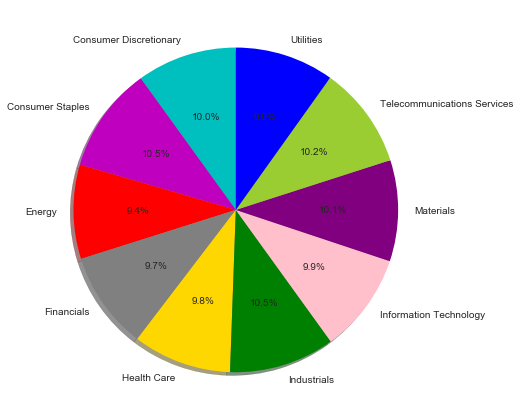

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import table
from matplotlib import cm

plt.figure(figsize=(16,8))
# plot chart

ax1 = plt.subplot(121, aspect='equal')
cols=['c','m','r','grey','gold','green','pink','purple','yellowgreen','blue']
plt.pie(1+((sector_plot.get_values())/100),labels=sector_plot.index,colors=cols,autopct='%1.1f%%', startangle=90, shadow=True)

plt.show()


# SUMMARY USING ONLY TOP AND BOTTOM QUANTILE

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                         
1               -3.00000  0.014132 -0.368904  0.602893    217  50.115473
20               0.06818  3.000000  0.732151  0.877298    216  49.884527

Returns Analysis


1
Ann. alpha                                      52.359
beta                                            -1.000
Mean Period Wise Return Top Quantile (bps)     149.301
Mean Period Wise Return Bottom Quantile (bps) -148.613
Mean Period Wise Spread (bps)                  298.598

Information Analysis


1
IC Mean       0.235
IC Std.       0.237
t-stat(IC)    2.966
p-value(IC)   0.018
IC Skew      -0.020
IC Kurtosis  -1.326
Ann. IR      15.695

Turnover Analysis


1
Quantile 1 Mean Turnover    0.103
Quantile 2 Mean Turnover      NaN
Quantile 3 Mean Turnover      NaN
Quantile 4 Mean Turnover      NaN
Quantile 5 Mean Turnover      NaN
Quantile 6 Mean Turnover      NaN
Quantile 7 Mean Turnover      NaN
Quantile 8 Mean Turnover      NaN
Quantile 9 Mean Turnover      NaN
Quantile 10 Mean Turnover     NaN
Quantile 11 Mean Turnover     NaN
Quantile 12 Mean Turnover     NaN
Quantile 13 Mean Turnover     NaN
Quantile 14 Mean Turnover     NaN
Quantile 15 Mean Turnover     NaN
Quantile 16 Mean Turnover     NaN
Quantile 17 Mean Turnover     NaN
Quantile 18 Mean Turnover     NaN
Quantile 19 Mean Turnover     NaN
Quantile 20 Mean Turnover   0.094

1
Mean Factor Rank Autocorrelation  0.98

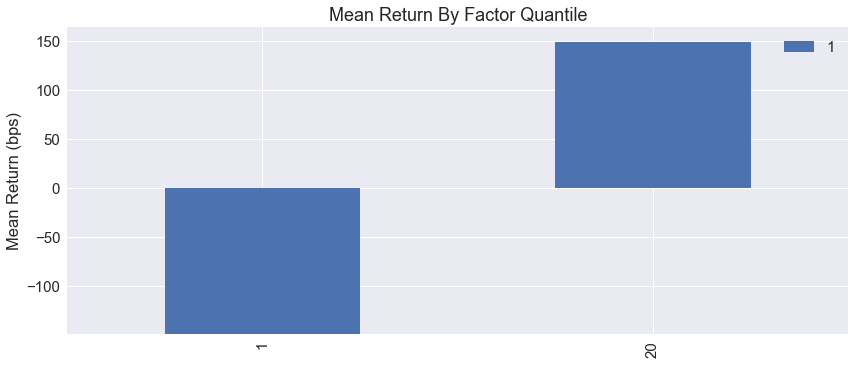

In [20]:
alphadetail.tears.create_summary_tear_sheet(factor_dataq)

# FULL SUMMARY USING ONLY TOP AND BOTTOM QUANTILE

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                         
1               -3.00000  0.014132 -0.368904  0.602893    217  50.115473
20               0.06818  3.000000  0.732151  0.877298    216  49.884527

Returns Analysis


1
Ann. alpha                                      52.359
beta                                            -1.000
Mean Period Wise Return Top Quantile (bps)     149.301
Mean Period Wise Return Bottom Quantile (bps) -148.613
Mean Period Wise Spread (bps)                  298.598

Information Analysis


1
IC Mean       0.235
IC Std.       0.237
t-stat(IC)    2.966
p-value(IC)   0.018
IC Skew      -0.020
IC Kurtosis  -1.326
Ann. IR      15.695

Turnover Analysis


1
Quantile 1 Mean Turnover    0.103
Quantile 2 Mean Turnover      NaN
Quantile 3 Mean Turnover      NaN
Quantile 4 Mean Turnover      NaN
Quantile 5 Mean Turnover      NaN
Quantile 6 Mean Turnover      NaN
Quantile 7 Mean Turnover      NaN
Quantile 8 Mean Turnover      NaN
Quantile 9 Mean Turnover      NaN
Quantile 10 Mean Turnover     NaN
Quantile 11 Mean Turnover     NaN
Quantile 12 Mean Turnover     NaN
Quantile 13 Mean Turnover     NaN
Quantile 14 Mean Turnover     NaN
Quantile 15 Mean Turnover     NaN
Quantile 16 Mean Turnover     NaN
Quantile 17 Mean Turnover     NaN
Quantile 18 Mean Turnover     NaN
Quantile 19 Mean Turnover     NaN
Quantile 20 Mean Turnover   0.094

1
Mean Factor Rank Autocorrelation  0.98

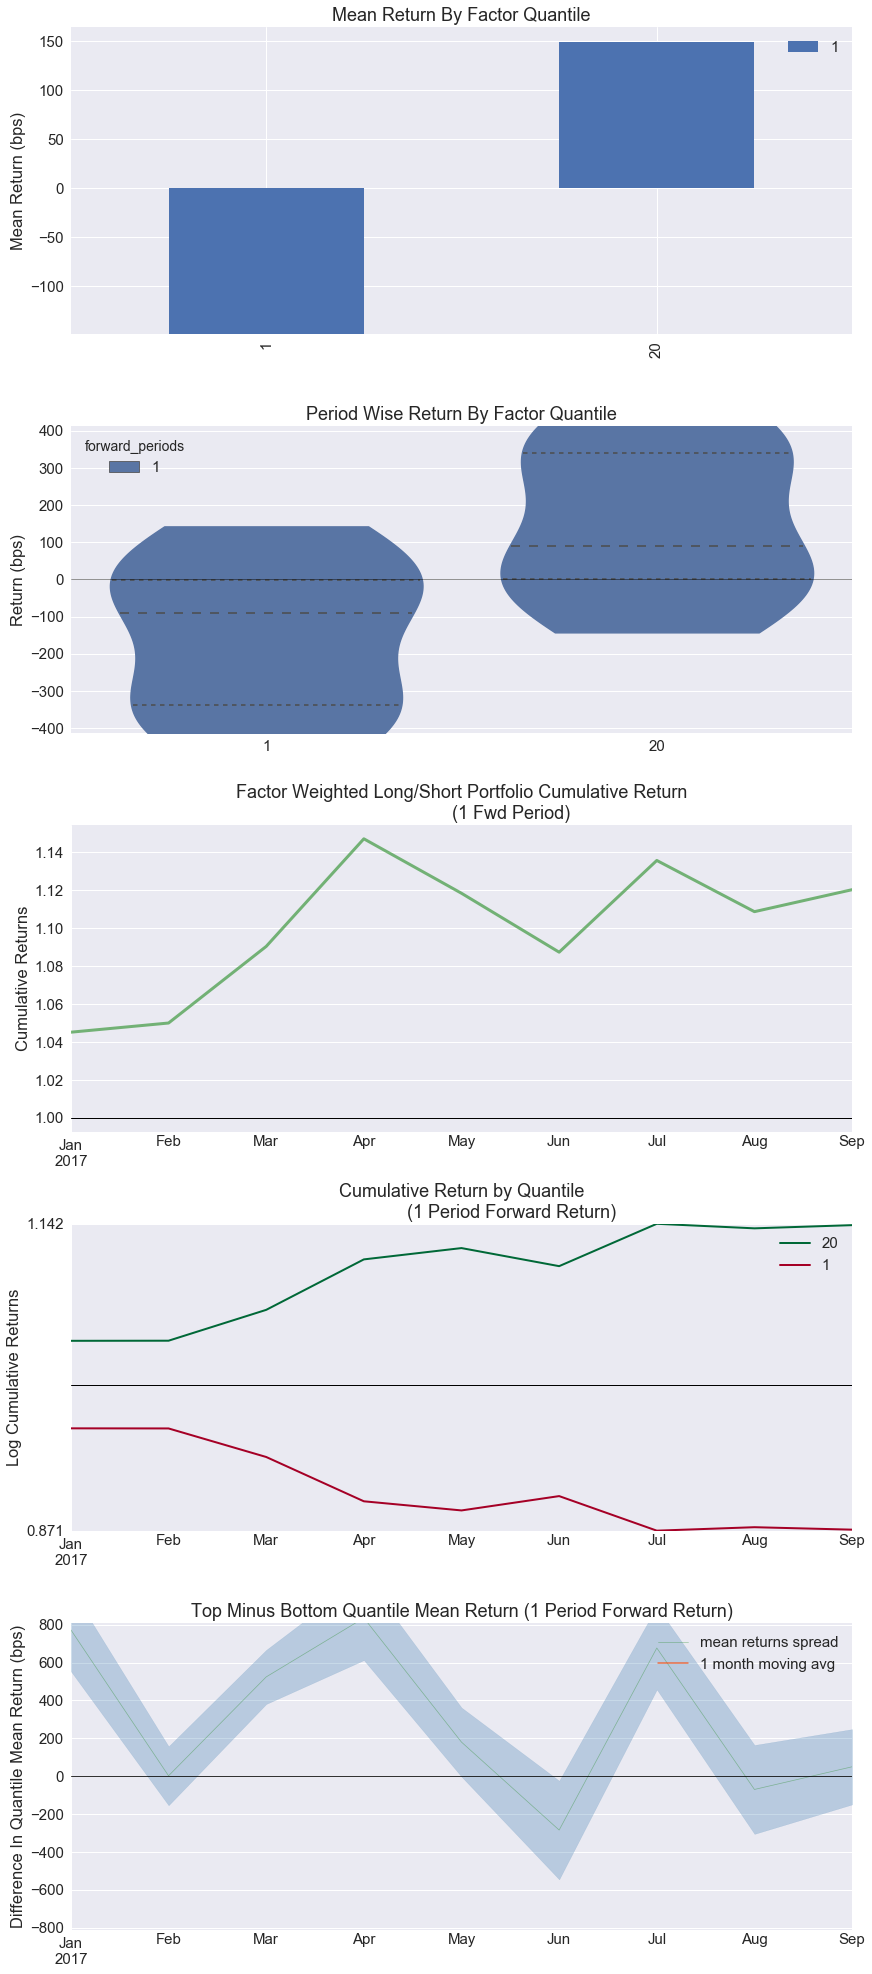

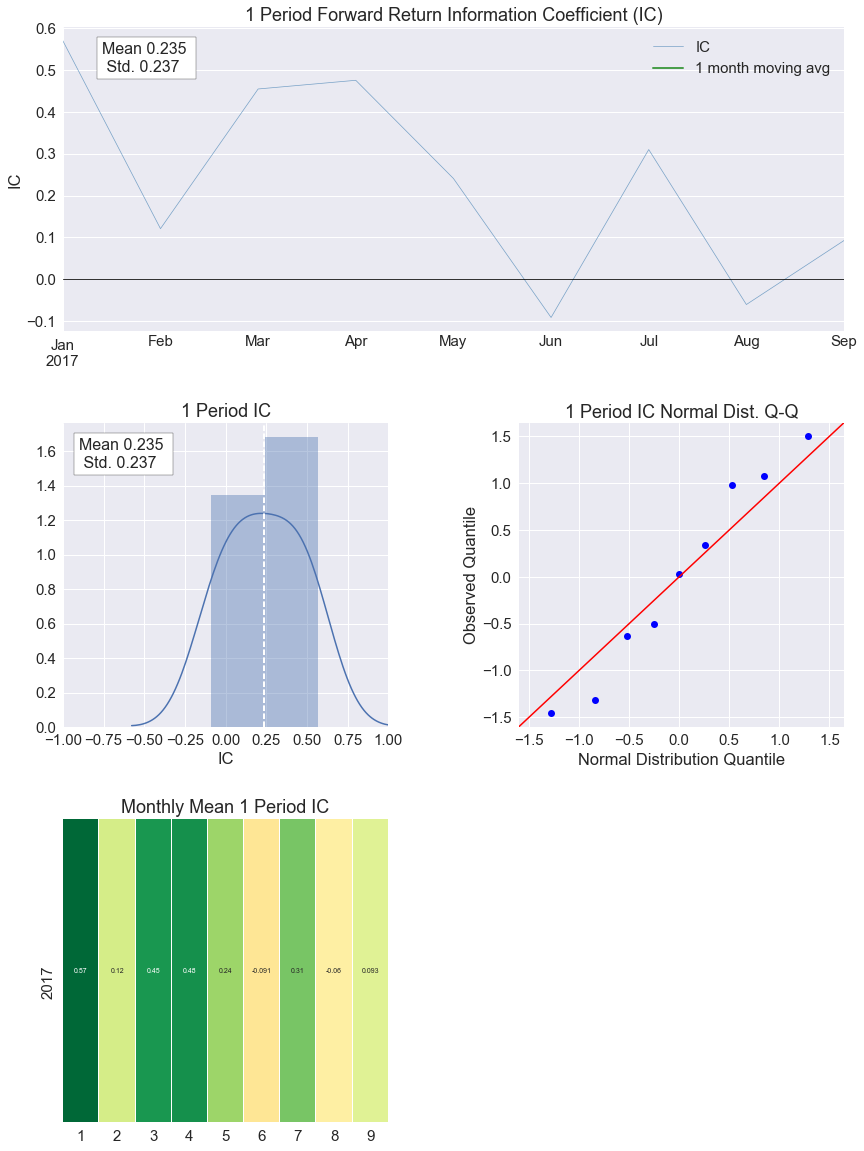

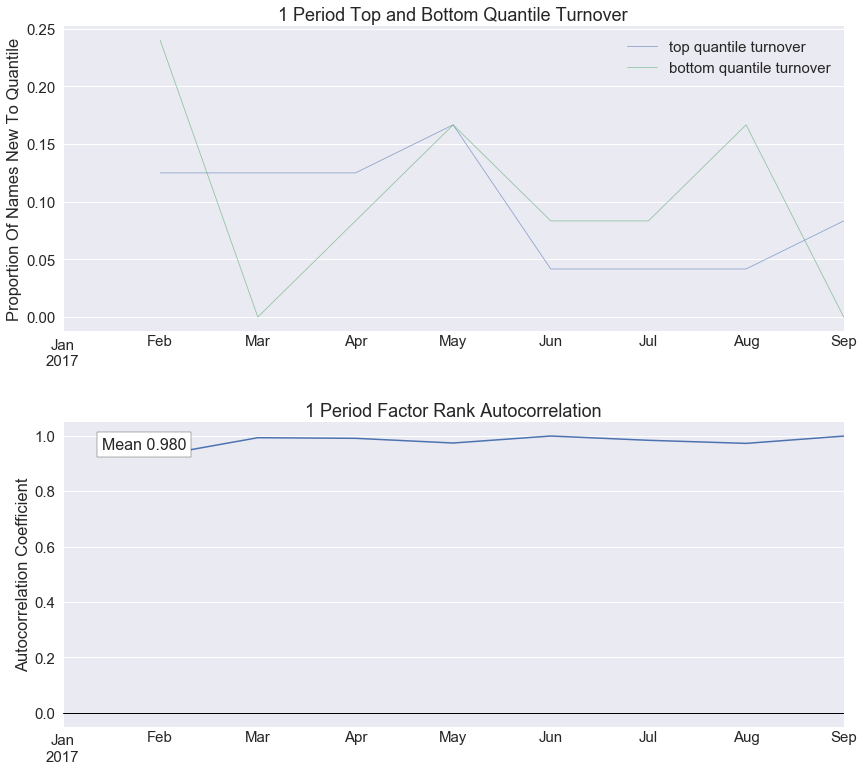

In [21]:
alphadetail.tears.create_full_tear_sheet(factor_dataq)

# FULL SUMMARY USING ALL QUANTILES

Quantiles Statistics


min       max      mean       std  count   count %
factor_quantile                                                         
1               -3.000000  0.014132 -0.368904  0.602893    217  5.034803
2               -0.589099  0.019348 -0.141952  0.142082    216  5.011601
3               -0.416331  0.023968 -0.114747  0.110924    216  5.011601
4               -0.343933  0.025602 -0.101042  0.096428    216  5.011601
5               -0.302216  0.026912 -0.092814  0.086937    216  5.011601
6               -0.271768  0.028299 -0.087026  0.081617    215  4.988399
7               -0.253994  0.029324 -0.081106  0.076562    213  4.941995
8               -0.234499  0.030563 -0.077194  0.072480    216  5.011601
9               -0.214114  0.032097 -0.070907  0.065984    216  5.011601
10              -0.186542  0.033549 -0.063933  0.059647    217  5.034803
11              -0.155270  0.035076 -0.057710  0.053968    212  4.918794
12              -0.130569  0.036627 -0.048874  0.048532    216  5.011601
13              -0.103886  0.038485 -0.040998  0.043146    217  5.034803
14              -0.071644  0.040535 -0.032357  0.039234    212  4.918794
15              -0.051314  0.042860 -0.022535  0.036450    216  5.011601
16              -0.044728  0.069391 -0.007309  0.038027    215  4.988399
17              -0.036380  0.158614  0.011061  0.048211    216  5.011601
18              -0.026110  0.315889  0.041095  0.076567    216  5.011601
19              -0.005565  0.897948  0.117420  0.166962    216  5.011601
20               0.068180  3.000000  0.732151  0.877298    216  5.011601

Returns Analysis


1
Ann. alpha                                      20.665
beta                                            -0.569
Mean Period Wise Return Top Quantile (bps)      63.990
Mean Period Wise Return Bottom Quantile (bps) -233.668
Mean Period Wise Spread (bps)                  298.598

Information Analysis


1
IC Mean      0.057
IC Std.      0.101
t-stat(IC)   1.692
p-value(IC)  0.129
IC Skew     -0.620
IC Kurtosis -0.838
Ann. IR      8.952

Turnover Analysis


1
Quantile 1 Mean Turnover    0.103
Quantile 2 Mean Turnover    0.177
Quantile 3 Mean Turnover    0.198
Quantile 4 Mean Turnover    0.193
Quantile 5 Mean Turnover    0.224
Quantile 6 Mean Turnover    0.220
Quantile 7 Mean Turnover    0.240
Quantile 8 Mean Turnover    0.292
Quantile 9 Mean Turnover    0.276
Quantile 10 Mean Turnover   0.244
Quantile 11 Mean Turnover   0.233
Quantile 12 Mean Turnover   0.234
Quantile 13 Mean Turnover   0.270
Quantile 14 Mean Turnover   0.257
Quantile 15 Mean Turnover   0.193
Quantile 16 Mean Turnover   0.173
Quantile 17 Mean Turnover   0.177
Quantile 18 Mean Turnover   0.177
Quantile 19 Mean Turnover   0.161
Quantile 20 Mean Turnover   0.094

1
Mean Factor Rank Autocorrelation  0.985

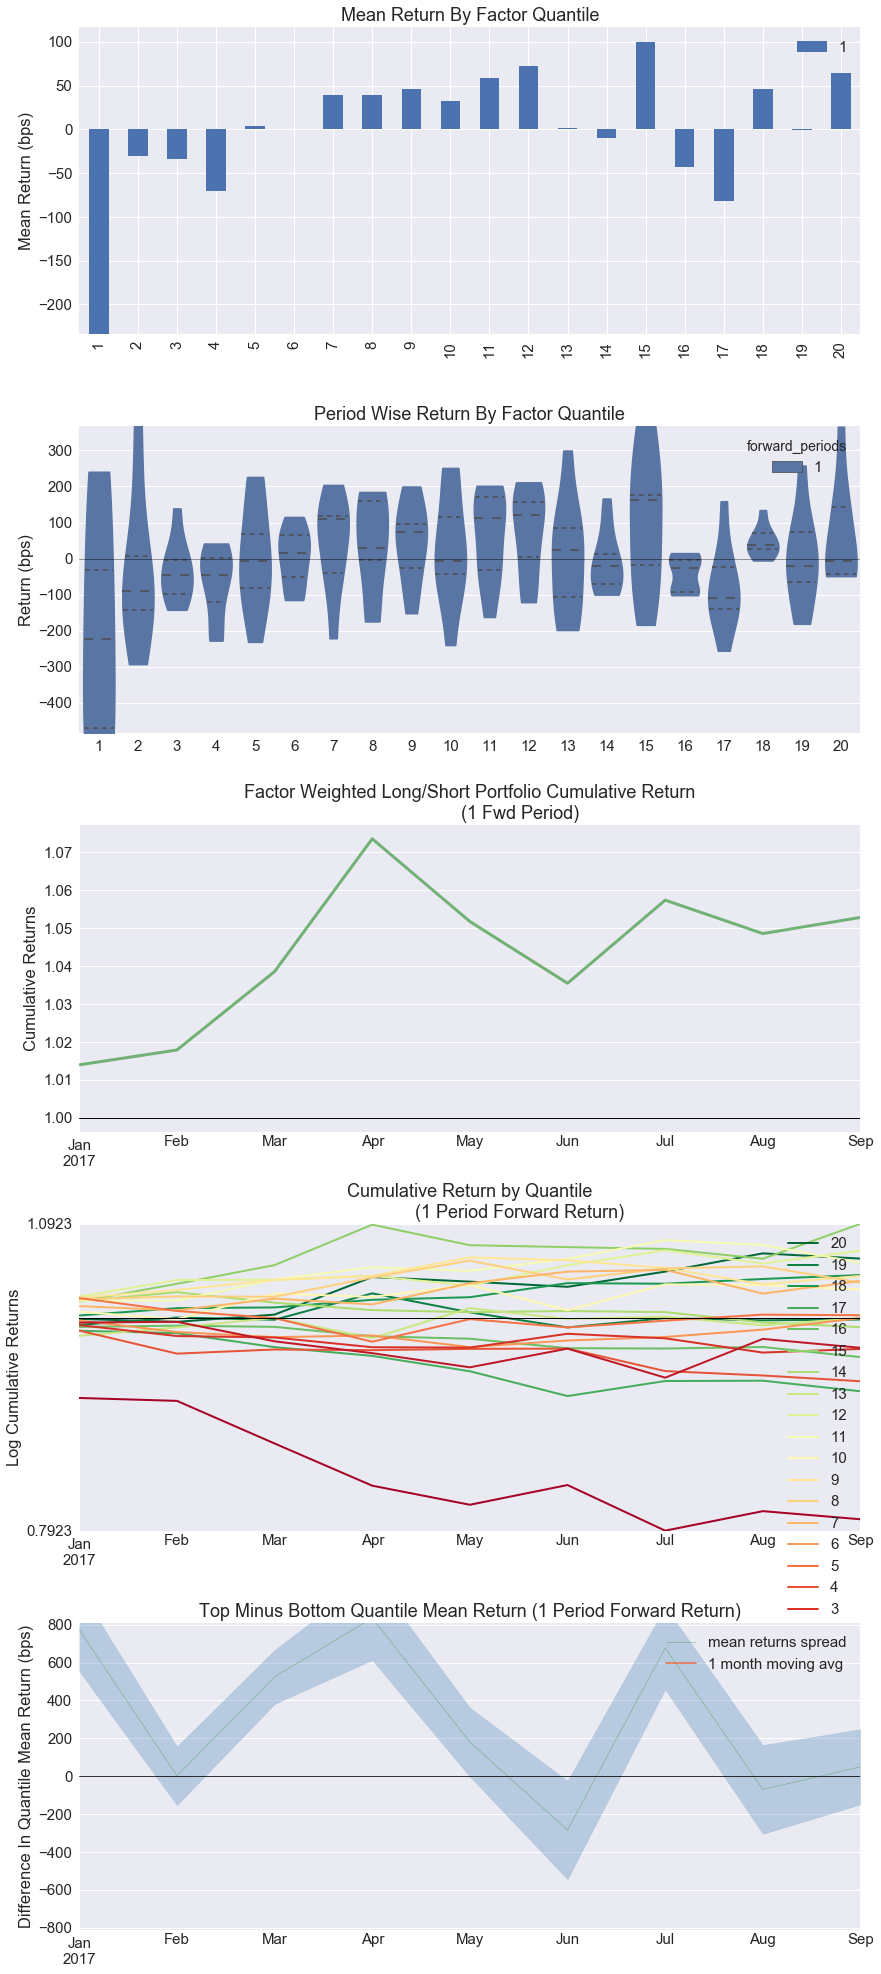

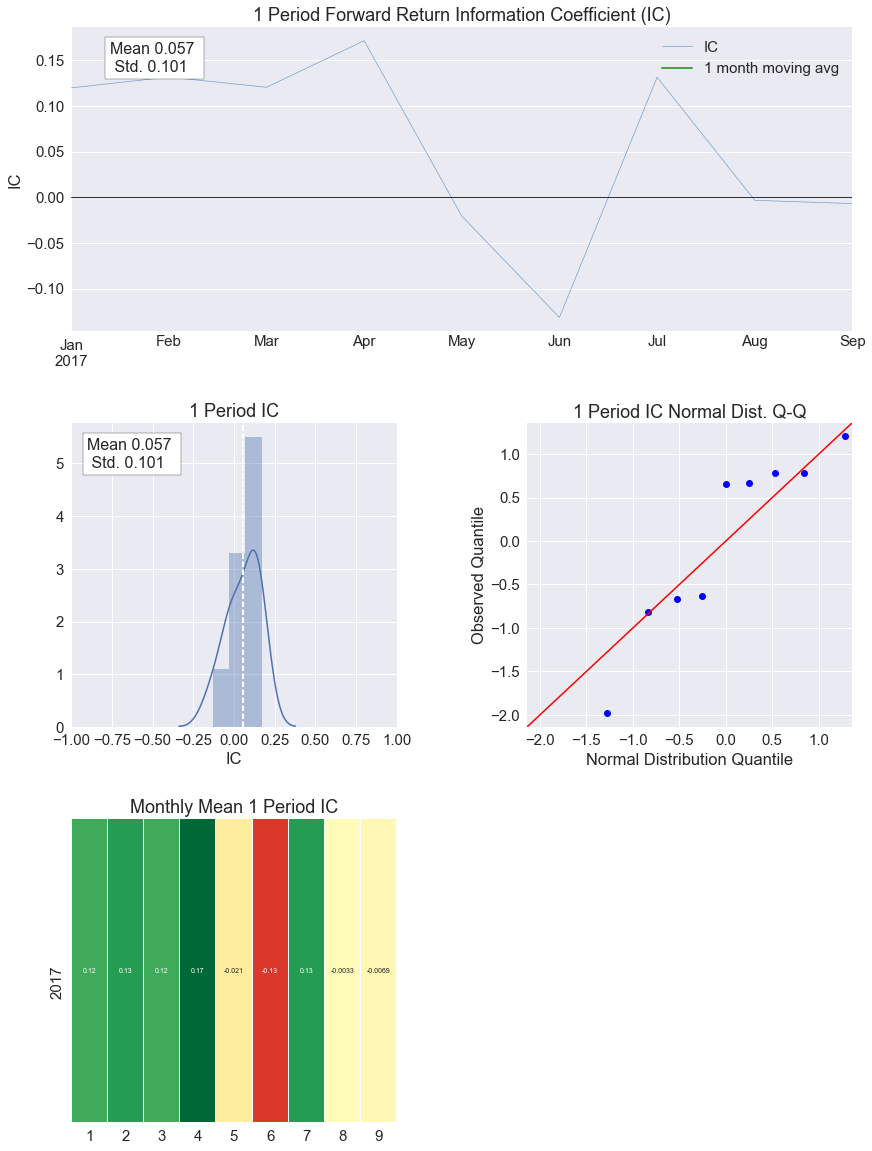

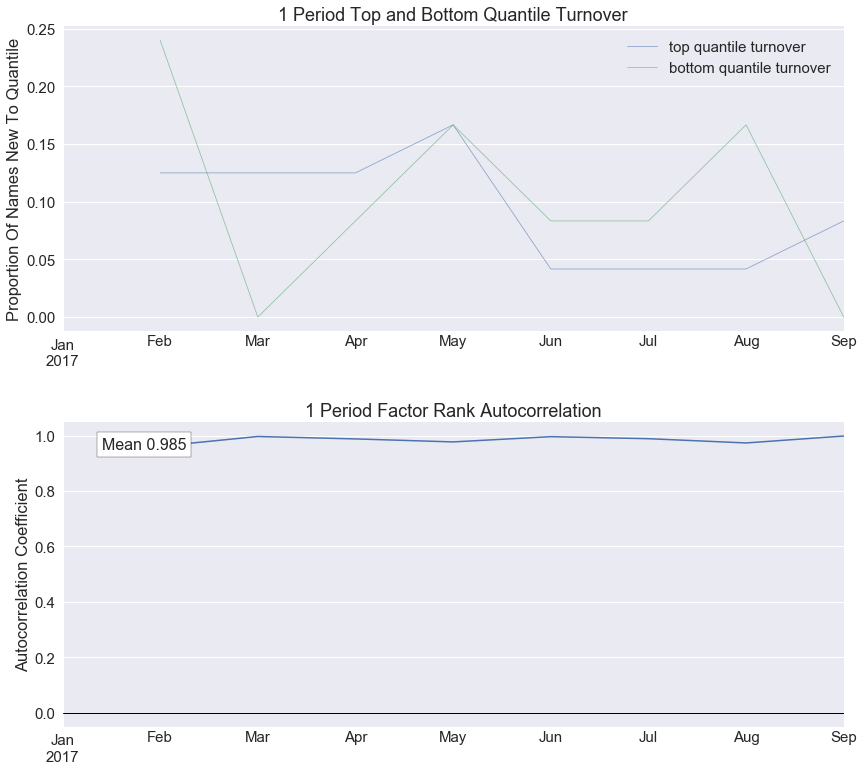

In [22]:
alphadetail.tears.create_full_tear_sheet(factor_data)

# SET BY_GROUP to true and do quantiling at sector level

In [23]:
#Find factor_data_sector but using by_group true
factor_data_sector = alphadetail.utils.get_clean_factor_and_forward_returns(predictive_factor, 
                                                                   pricing, 
                                                                   quantiles=None,
                                                                   bins=NUMSECTORBINS,
                                                                   groupby=ticker_sector,
                                                                   groupby_labels=sector_names,
                                                                   periods=([1]),
                                                                   by_group=True,
                                                                   filter_zscore=FLT_ZSCORE)

In [24]:
factor_data_sector.head()

1    factor        group  factor_quantile
date       asset                                                    
2017-01-31 1045.04  0.049944  0.740736  Industrials                2
           1075.01  0.058740 -0.250572    Utilities                5
           1078.01  0.079243 -0.332328  Health Care                1
           1177.01  0.085575 -0.189557  Health Care                2
           1209.01  0.005080 -0.078520    Materials                3

In [25]:
factor_data_sectorq = factor_data_sector[factor_data_sector['factor_quantile'].isin([1,NUMSECTORBINS])]
factor_data_sectorq#factor_data.loc[['2017-02-28','']]

1    factor                        group  \
date       asset                                                            
2017-01-31 1075.01    5.874018e-02 -0.250572                    Utilities   
           1078.01    7.924348e-02 -0.332328                  Health Care   
           1300.01    5.785159e-02  0.038103                  Industrials   
           1440.01    5.463628e-02 -0.360147                    Utilities   
           1447.01    4.818015e-02  0.029797                   Financials   
           1449.01    3.986284e-02 -0.186542                   Financials   
           1487.01   -5.291005e-03 -0.416331                   Financials   
           1598.01    5.616438e-02 -0.141836                  Industrials   
           1722.01    6.845911e-02 -0.268381             Consumer Staples   
           1878.01    6.097861e-02 -0.911756       Information Technology   
           2019.01    5.387883e-02 -0.263979                   Financials   
           2136.01    1.265048e-02  0.897948  Telecommunications Services   
           2176.02    4.435238e-02 -0.260457                   Financials   
           2184.01   -8.760108e-03  0.004145       Consumer Discretionary   
           2312.01   -3.611756e-01  0.156425                  Industrials   
           2574.01    5.065747e-02 -0.162443                  Industrials   
           2710.02    6.310096e-02 -0.071384             Consumer Staples   
           2817.01    1.045369e-02 -0.429509                  Industrials   
           2884.01   -6.187162e-02 -0.308503  Telecommunications Services   
           2968.01    7.077868e-02 -0.247556                   Financials   
           2991.01    2.002694e-02 -0.427935                       Energy   
           3026.01    1.063689e-01 -0.015557             Consumer Staples   
           3062.01    1.636379e-02  0.036267                  Industrials   
           3121.01    1.400833e-01  3.000000             Consumer Staples   
           3144.01    9.381766e-03  0.039688             Consumer Staples   
           3170.01    1.300712e-01  3.000000             Consumer Staples   
           3221.01    2.617569e-02  0.022872                   Financials   
           3226.01   -7.690268e-03 -0.125405       Consumer Discretionary   
           3231.01    5.553088e-02 -0.312730                   Financials   
           3243.01    7.415368e-02 -0.305727                   Financials   
           3336.01    1.022508e-01 -0.475650       Information Technology   
           3362.01    5.423382e-02 -0.239182             Consumer Staples   
           3413.01    4.546066e-02 -0.261908                    Utilities   
           3439.01    5.287559e-02 -0.166525                    Utilities   
           3505.01    4.434314e-02 -0.305873             Consumer Staples   
           3650.01    1.703966e-02 -0.138069                  Industrials   
           3735.01    1.942326e-02 -0.258543                  Health Care   
           3813.01   -7.924938e-02  0.031108       Consumer Discretionary   
           3835.01    2.279309e-02 -0.067202                  Industrials   
           3897.01    2.777778e-02 -0.262147                    Utilities   
           3980.01   -5.061003e-03 -0.071084       Consumer Discretionary   
           4016.02   -1.083717e-02 -0.025863       Consumer Discretionary   
           4029.01    1.782905e-02 -0.161522                    Utilities   
           4058.01    3.588424e-02 -0.177615                  Industrials   
           4093.01    6.194296e-02 -0.299970                    Utilities   
           4108.01   -5.512612e-02 -0.269334                  Industrials   
           4199.01    1.695394e-02 -0.200978                  Industrials   
           4321.01    3.273099e-02 -0.080313                  Industrials   
           4423.01    1.179229e-01 -0.065196                  Industrials   
           4430.01   -1.171037e-02 -0.440848                       Energy   
           4494.01    8.25652

In [26]:
# SUMMARY: ONLY BINS 1 and 5 in sectors

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000  0.287176 -0.070711  0.206436   2297  72.232704
5               -0.638157  3.000000  0.053005  0.525085    883  27.767296

Returns Analysis


1
Ann. alpha                                     30.754
beta                                           -0.864
Mean Period Wise Return Top Quantile (bps)     19.109
Mean Period Wise Return Bottom Quantile (bps)  -7.346
Mean Period Wise Spread (bps)                  32.639

Information Analysis


1
IC Mean      0.036
IC Std.      0.116
t-stat(IC)   0.938
p-value(IC)  0.376
IC Skew     -0.433
IC Kurtosis -0.919
Ann. IR      4.965

Turnover Analysis


1
Quantile 1 Mean Turnover   0.052
Quantile 2 Mean Turnover     NaN
Quantile 3 Mean Turnover     NaN
Quantile 4 Mean Turnover     NaN
Quantile 5 Mean Turnover   0.103

1
Mean Factor Rank Autocorrelation  0.984

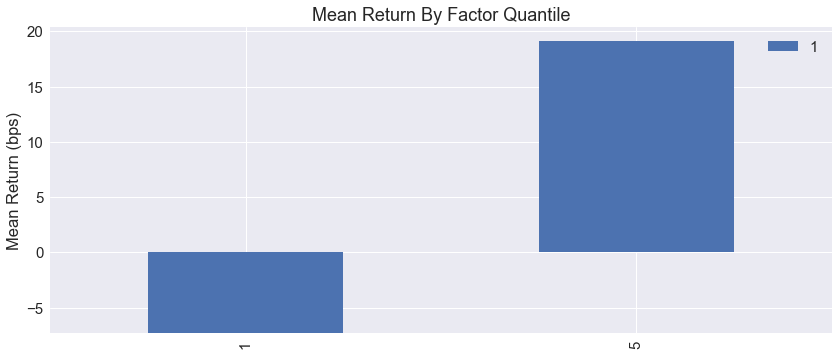

In [27]:
alphadetail.tears.create_summary_tear_sheet(factor_data_sectorq)

In [28]:
# DETAIL: ONLY BINS 1 and 5 in sectors

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000  0.287176 -0.070711  0.206436   2297  72.232704
5               -0.638157  3.000000  0.053005  0.525085    883  27.767296

Returns Analysis


1
Ann. alpha                                     30.754
beta                                           -0.864
Mean Period Wise Return Top Quantile (bps)     19.109
Mean Period Wise Return Bottom Quantile (bps)  -7.346
Mean Period Wise Spread (bps)                  32.639

Information Analysis


1
IC Mean      0.036
IC Std.      0.116
t-stat(IC)   0.938
p-value(IC)  0.376
IC Skew     -0.433
IC Kurtosis -0.919
Ann. IR      4.965

Turnover Analysis


1
Quantile 1 Mean Turnover   0.052
Quantile 2 Mean Turnover     NaN
Quantile 3 Mean Turnover     NaN
Quantile 4 Mean Turnover     NaN
Quantile 5 Mean Turnover   0.103

1
Mean Factor Rank Autocorrelation  0.984

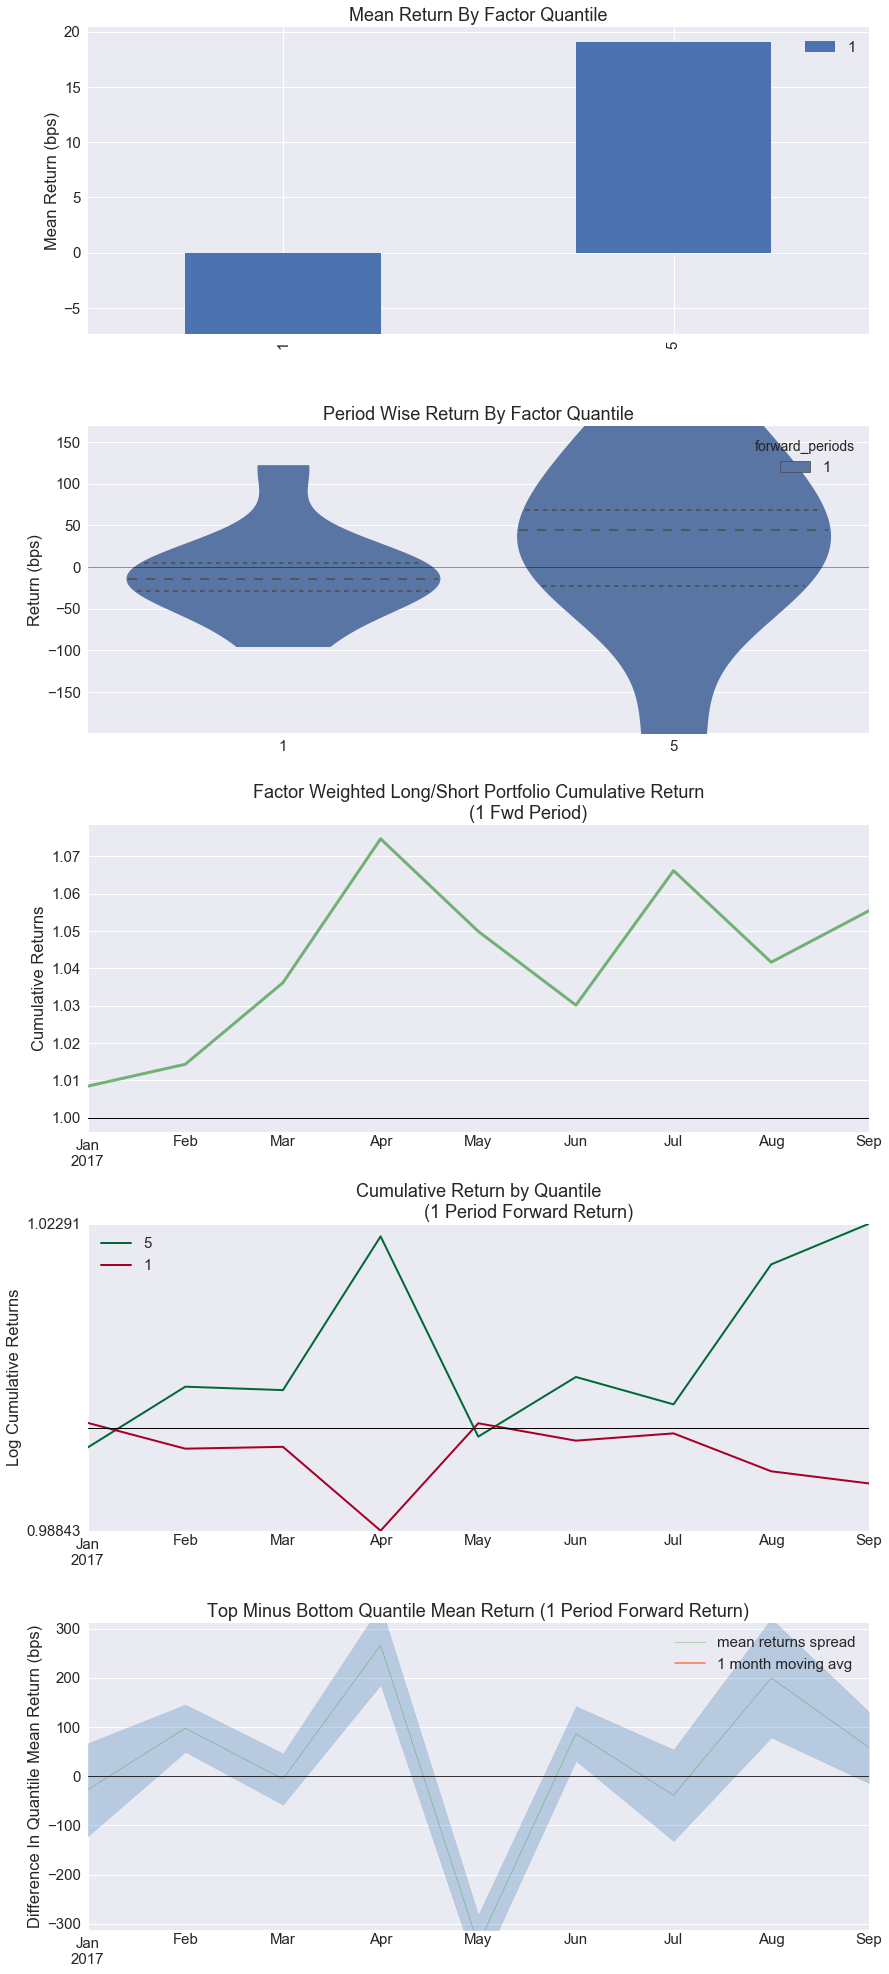

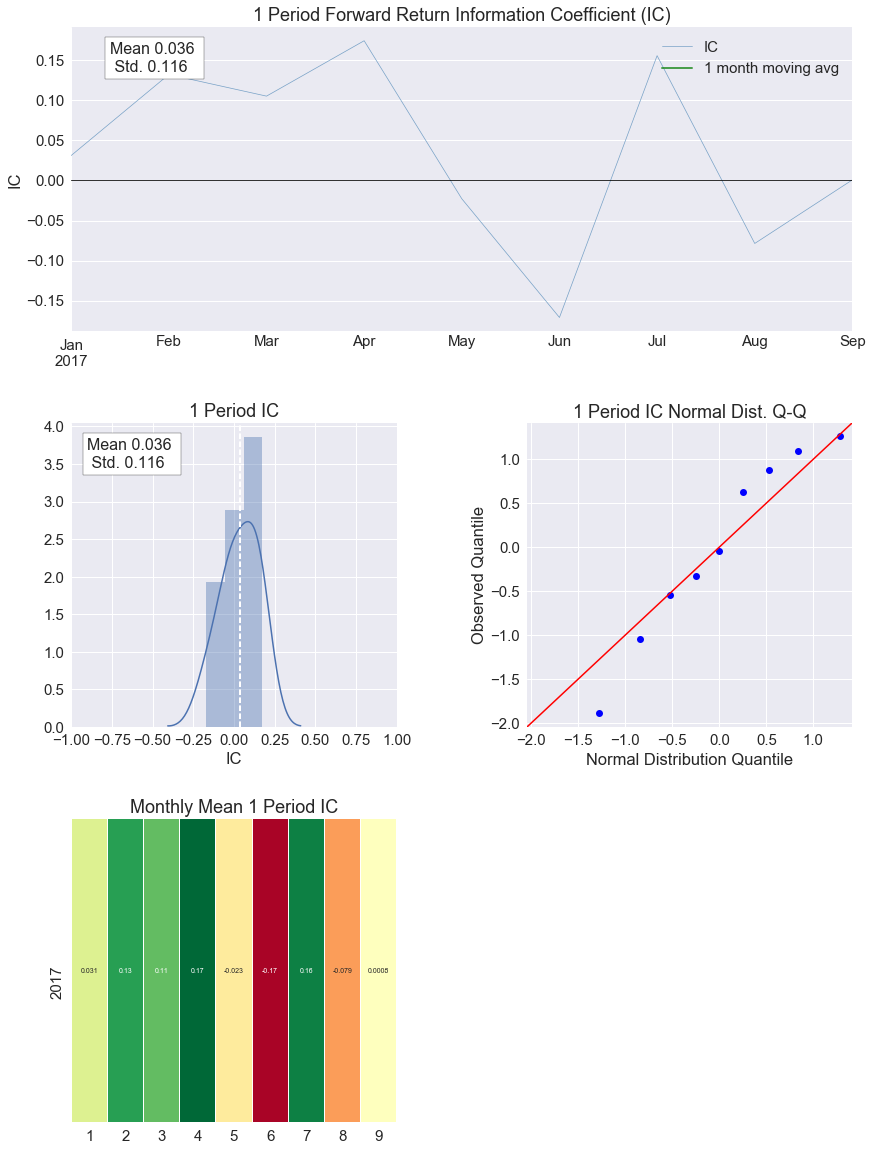

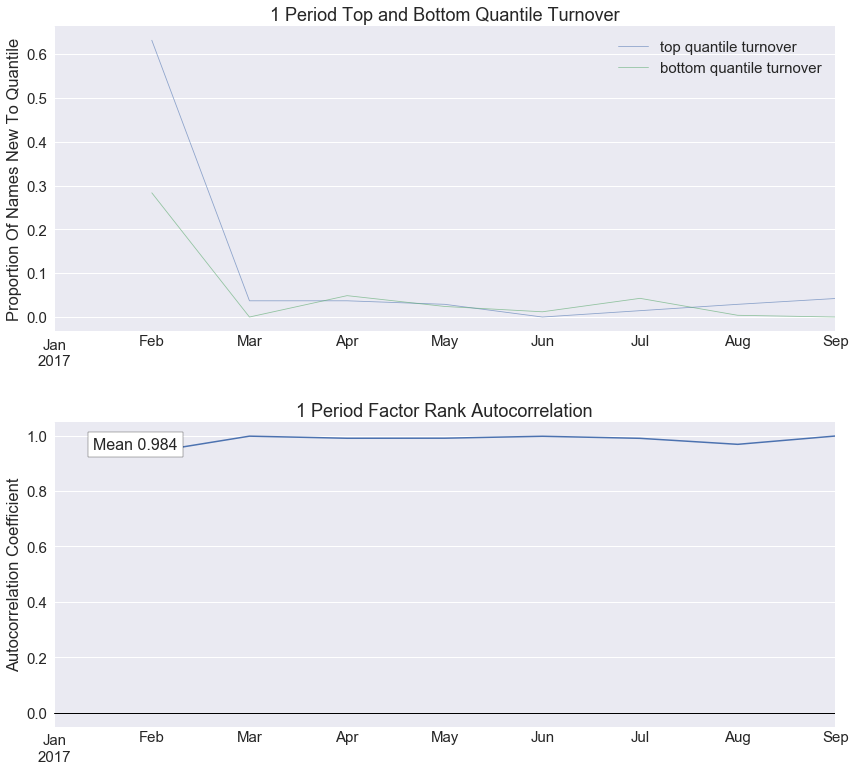

In [29]:
alphadetail.tears.create_full_tear_sheet(factor_data_sectorq)

In [30]:
# SUMMARY: ALL Sector Bins

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000  0.287176 -0.070711  0.206436   2297  53.294664
2               -2.059455  1.054419 -0.007709  0.213448    605  14.037123
3               -1.624772  1.519144  0.009874  0.258833    417   9.675174
4               -1.018801  2.156917  0.062331  0.507777    108   2.505800
5               -0.638157  3.000000  0.053005  0.525085    883  20.487239

Returns Analysis


1
Ann. alpha                                     20.665
beta                                           -0.569
Mean Period Wise Return Top Quantile (bps)     -6.144
Mean Period Wise Return Bottom Quantile (bps) -31.826
Mean Period Wise Spread (bps)                  32.639

Information Analysis


1
IC Mean      0.057
IC Std.      0.101
t-stat(IC)   1.692
p-value(IC)  0.129
IC Skew     -0.620
IC Kurtosis -0.838
Ann. IR      8.952

Turnover Analysis


1
Quantile 1 Mean Turnover   0.052
Quantile 2 Mean Turnover   0.320
Quantile 3 Mean Turnover   0.352
Quantile 4 Mean Turnover   0.365
Quantile 5 Mean Turnover   0.103

1
Mean Factor Rank Autocorrelation  0.985

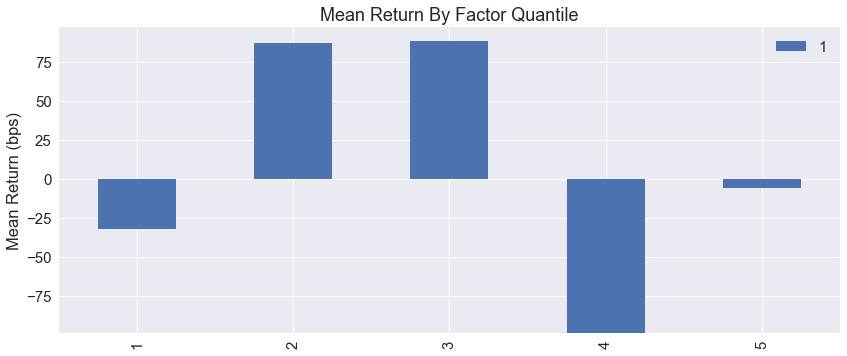

In [31]:
alphadetail.tears.create_summary_tear_sheet(factor_data_sector)

In [32]:
# DETAIL: ALL Sector Bins

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000  0.287176 -0.070711  0.206436   2297  53.294664
2               -2.059455  1.054419 -0.007709  0.213448    605  14.037123
3               -1.624772  1.519144  0.009874  0.258833    417   9.675174
4               -1.018801  2.156917  0.062331  0.507777    108   2.505800
5               -0.638157  3.000000  0.053005  0.525085    883  20.487239

Returns Analysis


1
Ann. alpha                                     20.665
beta                                           -0.569
Mean Period Wise Return Top Quantile (bps)     -6.144
Mean Period Wise Return Bottom Quantile (bps) -31.826
Mean Period Wise Spread (bps)                  32.639

Information Analysis


1
IC Mean      0.057
IC Std.      0.101
t-stat(IC)   1.692
p-value(IC)  0.129
IC Skew     -0.620
IC Kurtosis -0.838
Ann. IR      8.952

Turnover Analysis


1
Quantile 1 Mean Turnover   0.052
Quantile 2 Mean Turnover   0.320
Quantile 3 Mean Turnover   0.352
Quantile 4 Mean Turnover   0.365
Quantile 5 Mean Turnover   0.103

1
Mean Factor Rank Autocorrelation  0.985

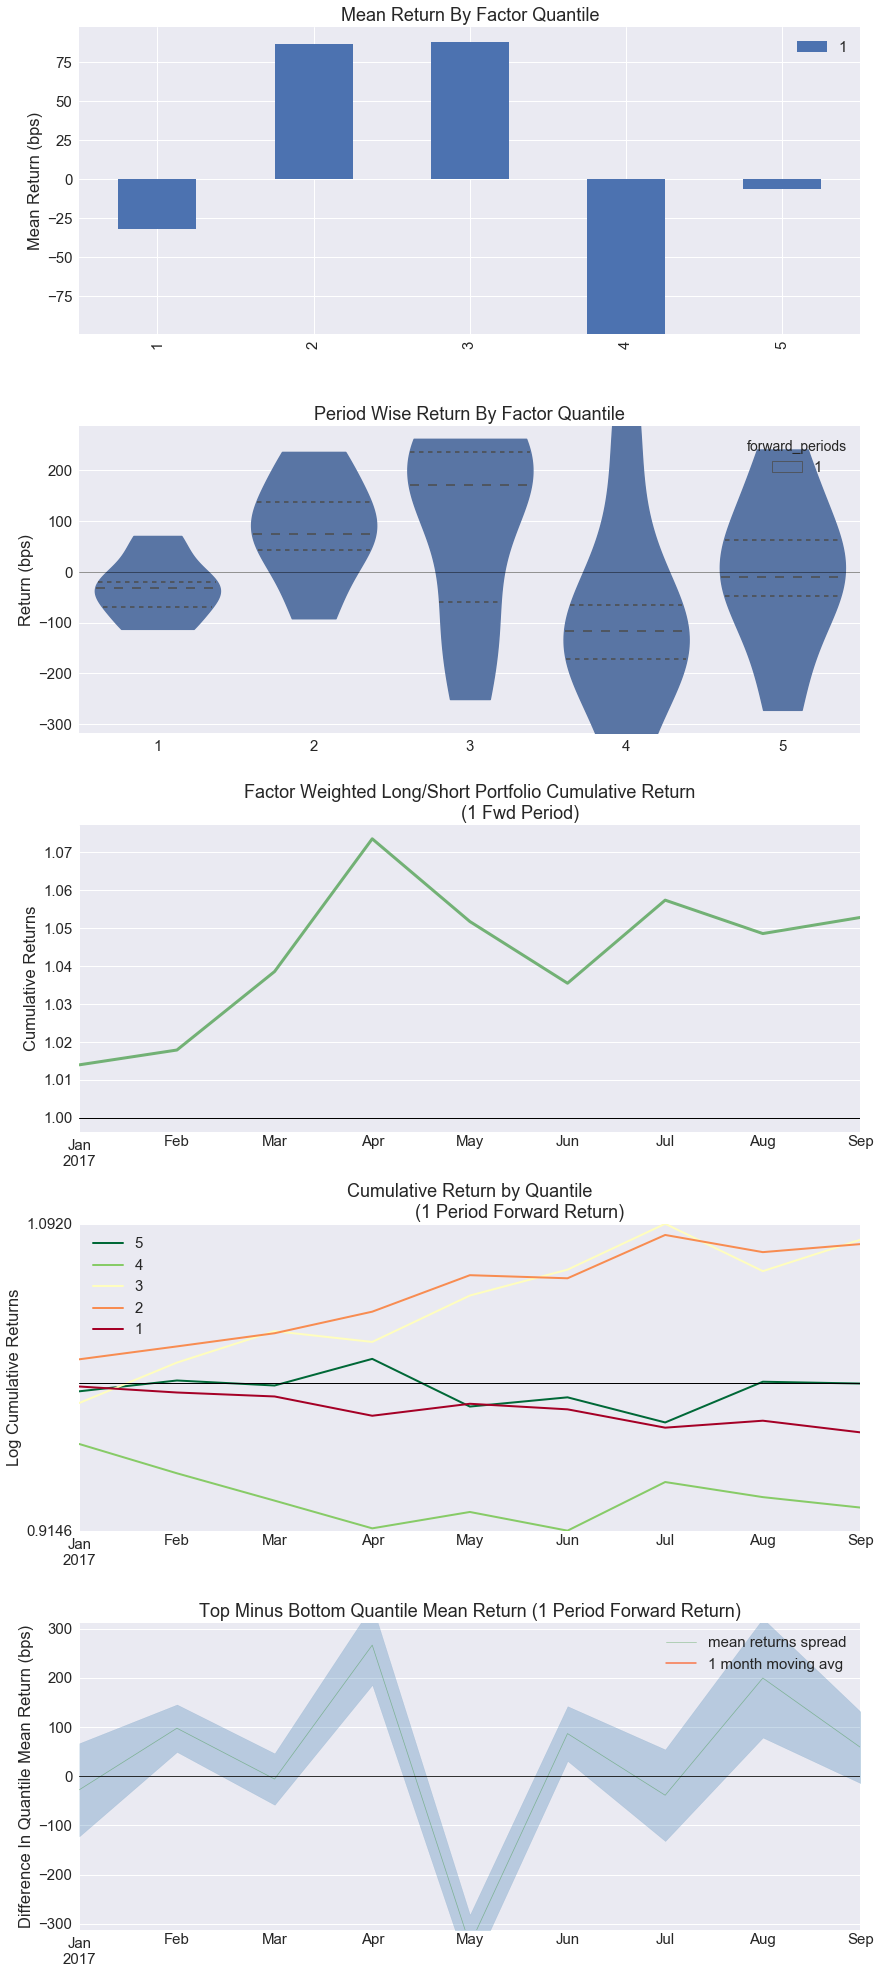

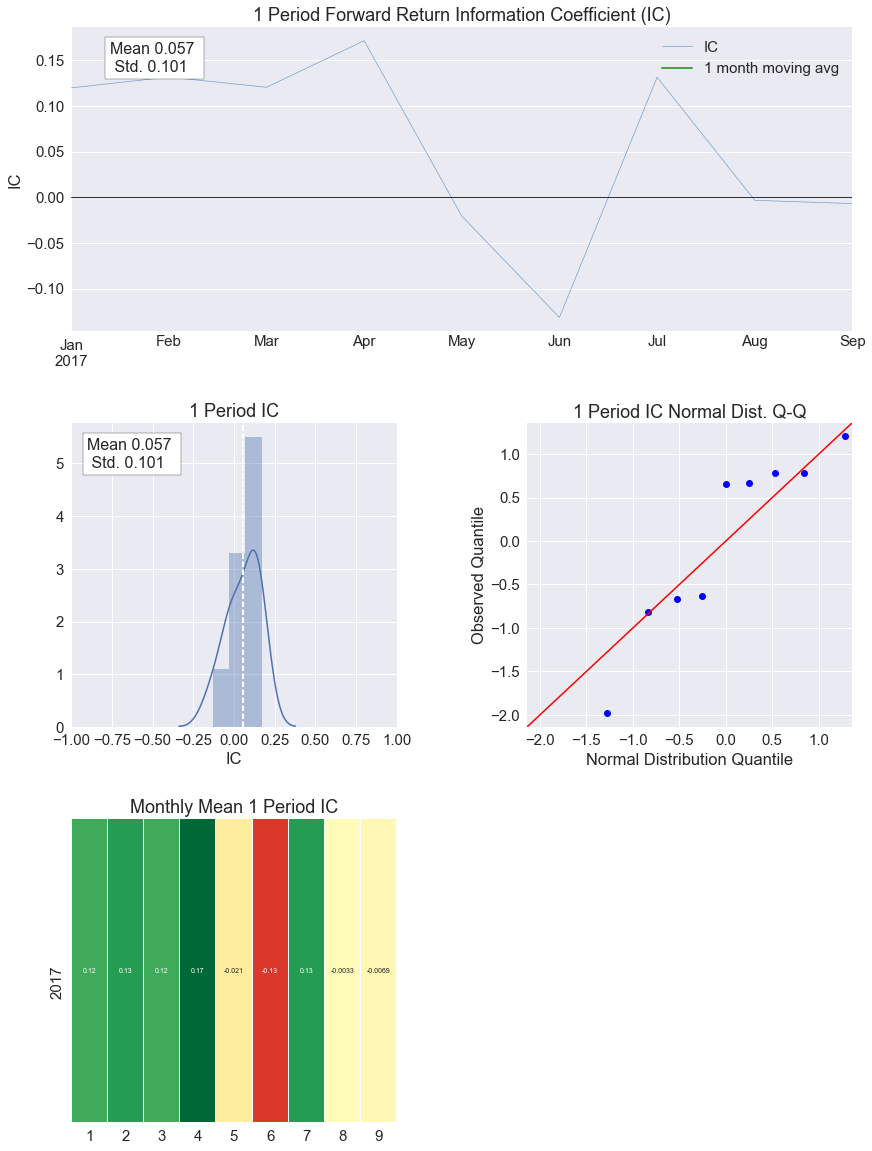

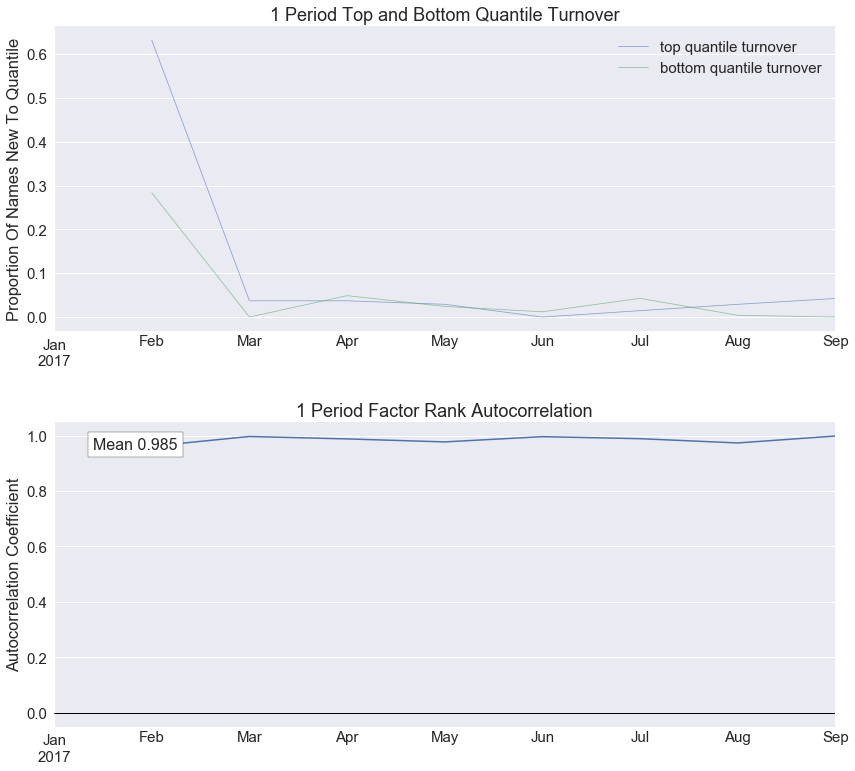

In [33]:
alphadetail.tears.create_full_tear_sheet(factor_data_sector)